In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from torch import nn, optim
from torch.nn import functional as F

## 1. 数据准备
下载 MNIST 图像，构建数据集

In [2]:
# https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html

mnist_train_data = torchvision.datasets.MNIST('./data', train=True, download=True,transform=transforms.ToTensor())

In [3]:
mnist_test_data = torchvision.datasets.MNIST('./data', train=False, download=True,transform=transforms.ToTensor())

<Figure size 640x480 with 0 Axes>

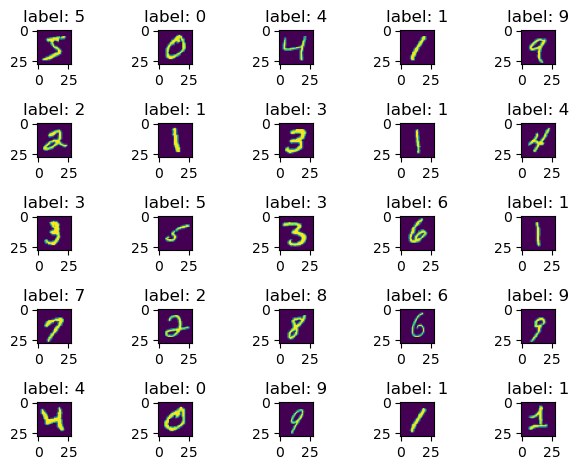

In [4]:
ds_images,ds_targets=(mnist_train_data._load_data())
fig = plt.figure()#生成图框
fig = plt.figure()
for i, c in enumerate(ds_targets[:25]):
    plt.subplot(5,5,i+1) 
    plt.tight_layout()#调整间距
    plt.imshow(ds_images[i], interpolation='none')
    plt.imshow(ds_images[i])
    plt.title("label: {}".format(ds_targets[i]))
plt.show()

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train_data,batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test_data,batch_size=128, shuffle=False)

In [6]:
tmp = next(iter(train_loader))

In [7]:
tmp[0].shape, tmp[1].shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

# 2. 构建模型

## 2.1 VAE模型架构

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
device = torch.device('cuda')

In [10]:
model = VAE().to(device)

In [11]:
model

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

## 2.2 训练细节
损失函数、优化器、train函数

In [12]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [14]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % (len(train_loader)//3) == 0:
            print('Train Epoch: {:} [{:}/{:} ({:.2f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [15]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 24)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(128, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# 3. 训练2个epoch

In [16]:
for epoch in range(2):
    train(epoch)
    test(epoch)
    # sample0 = torch.randn(64, 20).to(device)
    # with torch.no_grad():
    #     sample1 = model.decode(sample0).cpu()
    #     save_image(sample1.view(64, 1, 28, 28),
    #                'results/sample_' + str(epoch) + '.png')

Train Epoch: 0 [0/60000 (0.00%)]	Loss: 549.512207
Train Epoch: 0 [19968/60000 (33.26%)]	Loss: 151.703583
Train Epoch: 0 [39936/60000 (66.52%)]	Loss: 137.187378
Train Epoch: 0 [44928/60000 (99.79%)]	Loss: 122.101196
====> Epoch: 0 Average loss: 163.6407
====> Test set loss: 126.8281
Train Epoch: 1 [0/60000 (0.00%)]	Loss: 126.984718
Train Epoch: 1 [19968/60000 (33.26%)]	Loss: 128.627686
Train Epoch: 1 [39936/60000 (66.52%)]	Loss: 119.608963
Train Epoch: 1 [44928/60000 (99.79%)]	Loss: 114.534932
====> Epoch: 1 Average loss: 120.8086
====> Test set loss: 115.3030


## 生成
随机进行64个抽样，生成图片

In [17]:
for i in range(4):
    rand_sample = torch.randn(64,20).cuda()
    with torch.no_grad():
        rand_sample_dec = model.decode(rand_sample).cpu()
    save_image(rand_sample_dec.view(64, 1, 28, 28),'./gen/vae-generate-2epoch-'+str(i)+'.jpg')

gen_images = []
for i in range(4):
    gen_images.append(Image.open('./gen/vae-generate-2epoch-'+str(i)+'.jpg'))

<Figure size 640x480 with 0 Axes>

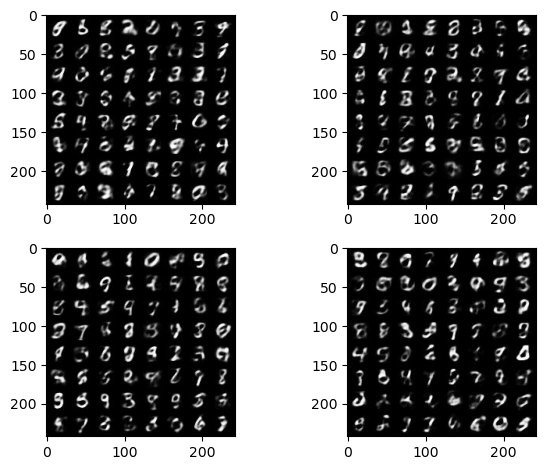

In [18]:
fig = plt.figure()#生成图框
fig = plt.figure()
for i, c in enumerate(gen_images):
    plt.subplot(2,2,i+1) 
    plt.tight_layout()#调整间距
    plt.imshow(gen_images[i], interpolation='none')
    plt.imshow(gen_images[i])
plt.show()

# 4. 训练20个epoch

In [19]:
for epoch in range(20):
    train(epoch)
    test(epoch)

Train Epoch: 0 [0/60000 (0.00%)]	Loss: 117.786430
Train Epoch: 0 [19968/60000 (33.26%)]	Loss: 112.081146
Train Epoch: 0 [39936/60000 (66.52%)]	Loss: 112.486130
Train Epoch: 0 [44928/60000 (99.79%)]	Loss: 104.976562
====> Epoch: 0 Average loss: 114.2350
====> Test set loss: 111.5772
Train Epoch: 1 [0/60000 (0.00%)]	Loss: 112.970016
Train Epoch: 1 [19968/60000 (33.26%)]	Loss: 105.201797
Train Epoch: 1 [39936/60000 (66.52%)]	Loss: 108.338951
Train Epoch: 1 [44928/60000 (99.79%)]	Loss: 117.949972
====> Epoch: 1 Average loss: 111.3021
====> Test set loss: 109.4149
Train Epoch: 2 [0/60000 (0.00%)]	Loss: 113.544281
Train Epoch: 2 [19968/60000 (33.26%)]	Loss: 110.347763
Train Epoch: 2 [39936/60000 (66.52%)]	Loss: 110.543922
Train Epoch: 2 [44928/60000 (99.79%)]	Loss: 110.033508
====> Epoch: 2 Average loss: 109.6100
====> Test set loss: 108.2265
Train Epoch: 3 [0/60000 (0.00%)]	Loss: 105.419533
Train Epoch: 3 [19968/60000 (33.26%)]	Loss: 113.279350
Train Epoch: 3 [39936/60000 (66.52%)]	Loss: 10

In [20]:
for i in range(4):
    rand_sample = torch.randn(64,20).cuda()
    with torch.no_grad():
        rand_sample_dec = model.decode(rand_sample).cpu()
    save_image(rand_sample_dec.view(64, 1, 28, 28),'./gen/vae-generate-20epoch-'+str(i)+'.jpg')

gen_images = []
for i in range(4):
    gen_images.append(Image.open('./gen/vae-generate-20epoch-'+str(i)+'.jpg'))

<Figure size 640x480 with 0 Axes>

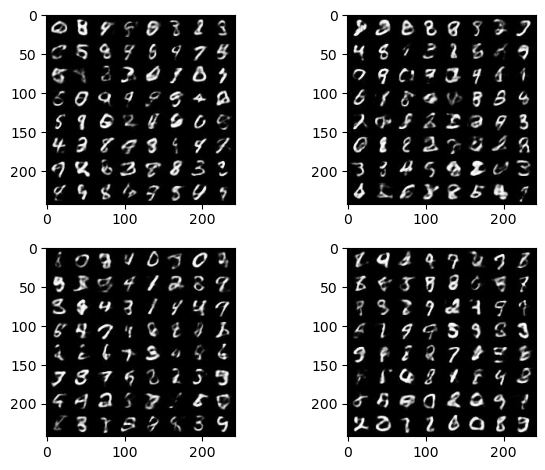

In [21]:
fig = plt.figure()#生成图框
fig = plt.figure()
for i, c in enumerate(gen_images):
    plt.subplot(2,2,i+1) 
    plt.tight_layout()#调整间距
    plt.imshow(gen_images[i], interpolation='none')
    plt.imshow(gen_images[i])
plt.show()